Load Your Data (CSV)

In [6]:
!pip install pm4py

In [2]:
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

# Load CSV
df = pd.read_csv("incidentProcess_custom.csv", sep="\t")


df['ActivityTimeStamp'] = pd.to_datetime(df['ActivityTimeStamp'])

# Rename columns for PM4Py
df = df.rename(columns={
    'Incident ID': 'case:concept:name',
    'Activity': 'concept:name',
    'ActivityTimeStamp': 'time:timestamp'
})

# Apply standard PM4Py formatting
df = dataframe_utils.convert_timestamp_columns_in_df(df)
log = log_converter.apply(df)


In [8]:
df.columns

Index(['case:concept:name', 'concept:name', 'time:timestamp', 'Asset Affected',
       'Asset Type Affected', 'Asset SubType Affected', 'Service Affected',
       'Status', 'Impact', 'Urgency', 'Priority', 'Category',
       'Number of Reassignments', 'Open Time', 'Reopen Time', 'Resolved Time',
       'Close Time', 'Handle Time (Hours)', 'Closure Code', 'Asset Caused',
       'Asset Type Caused', 'Asset SubType Caused', 'Service Caused',
       'Assignment Group'],
      dtype='object')

In [10]:
import pandas as pd

# Load your CSV (tab-separated)
df = pd.read_csv("incidentProcess_custom.csv", sep="\t")

# Convert to datetime
df['Open Time'] = pd.to_datetime(df['Open Time'], dayfirst=True, errors='coerce')
df['Close Time'] = pd.to_datetime(df['Close Time'], dayfirst=True, errors='coerce')


# Calculate handling time in hours (if not already present)
df['HandleTimeHours'] = (df['Close Time'] - df['Open Time']).dt.total_seconds() / 3600

# Optional: clean column names
df.columns = df.columns.str.strip()

# Group by Priority and Incident Type (Category)
grouped_priority_category = df.groupby(['Priority', 'Category'])['HandleTimeHours'].mean().reset_index()
grouped_priority_category.rename(columns={'HandleTimeHours': 'AvgHandleTimeHours'}, inplace=True)

# Group by Assignment Group
grouped_assignment = df.groupby(['Assignment Group'])['HandleTimeHours'].mean().reset_index()
grouped_assignment.rename(columns={'HandleTimeHours': 'AvgHandleTimeHours'}, inplace=True)

# Group by Asset Type Affected
grouped_asset_type = df.groupby(['Asset Type Affected'])['HandleTimeHours'].mean().reset_index()
grouped_asset_type.rename(columns={'HandleTimeHours': 'AvgHandleTimeHours'}, inplace=True)


In [11]:
from IPython.display import display

print("👉 Average Handle Time by Priority and Category")
display(grouped_priority_category.sort_values(by="AvgHandleTimeHours", ascending=False))

print("👉 Average Handle Time by Assignment Group")
display(grouped_assignment.sort_values(by="AvgHandleTimeHours", ascending=False))

print("👉 Average Handle Time by Asset Type Affected")
display(grouped_asset_type.sort_values(by="AvgHandleTimeHours", ascending=False))


👉 Average Handle Time by Priority and Category


Priority                 Category  AvgHandleTimeHours
7          5                complaint          346.959401
5          4                 incident          295.418302
8          5                 incident          292.353909
10         5  request for information          287.792828
6          4  request for information          276.973225
3          3                 incident          213.729136
4          3  request for information          207.394489
9          5       request for change          170.876111
0          1                 incident           72.753611
1          2                 incident           33.098573
2          2  request for information            2.464076

👉 Average Handle Time by Assignment Group


Assignment Group  AvgHandleTimeHours
5           TEAM0006        10075.858056
25          TEAM0026         3844.460185
10          TEAM0011         3347.652623
4           TEAM0005         3145.829946
8           TEAM0009         2999.795322
..               ...                 ...
149         TEAM0150           18.287500
224         TEAM0226           15.101053
154         TEAM0155           12.598437
104         TEAM0105            5.553587
175         TEAM0177            3.646111

[241 rows x 2 columns]

👉 Average Handle Time by Asset Type Affected


Asset Type Affected  AvgHandleTimeHours
2            application          297.790853
12        subapplication          278.545871
6          displaydevice          240.690253
1                  Phone          197.403056
4               computer          190.353263
0                   #N/B          140.589990
7               hardware          131.924327
11               storage          110.329187
10              software          110.133682
8      networkcomponents           86.587117
9      officeelectronics           62.255691
5               database           60.151467
3   applicationcomponent           42.586314

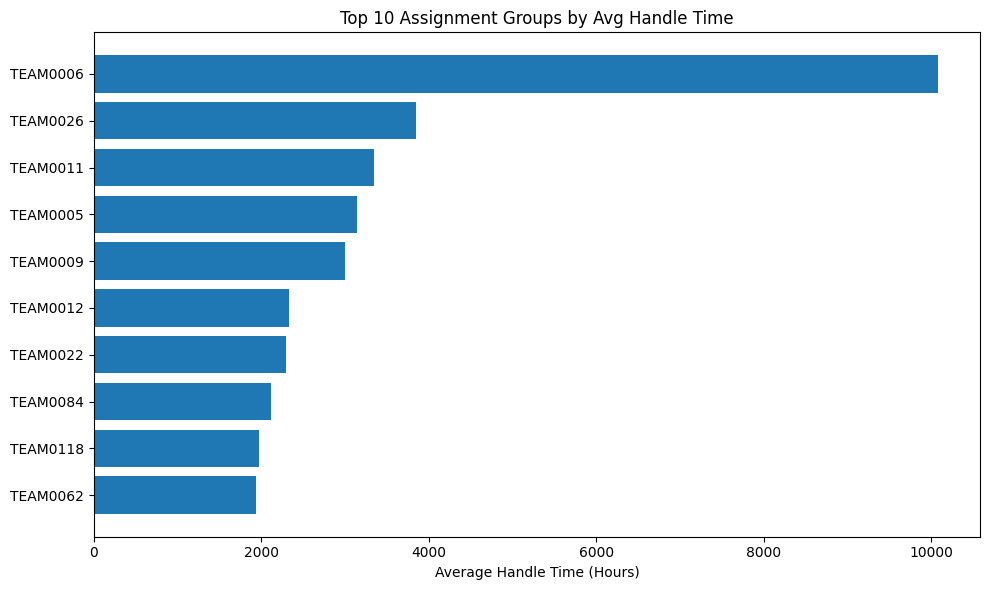

In [12]:
import matplotlib.pyplot as plt


grouped_assignment_sorted = grouped_assignment.sort_values(by="AvgHandleTimeHours", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(grouped_assignment_sorted['Assignment Group'], grouped_assignment_sorted['AvgHandleTimeHours'])
plt.xlabel("Average Handle Time (Hours)")
plt.title("Top 10 Assignment Groups by Avg Handle Time")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [9]:
from pm4py.statistics.traces.generic.log import case_statistics

# Example usage:
variants_count = case_statistics.get_variant_statistics(log)
print("Top variants:")
for v in variants_count[:5]:
    print(v)


Top variants:
{'variant': ('Open', 'Assign to 1st Line Operator', 'Close', 'Set Asset Caused'), 'count': 6123}
{'variant': ('Open', 'Assign to 1st Line Operator', 'Set Asset Caused', 'Close'), 'count': 4395}
{'variant': ('Open', 'Close', 'Set Asset Caused'), 'count': 2982}
{'variant': ('Open', 'Assign to 1st Line Operator', 'Close'), 'count': 2512}
{'variant': ('Open', 'Assign to 1st Line Operator', 'Mail to Customer', 'Close'), 'count': 1712}


In [10]:
from pm4py.statistics.start_activities.log import get as start_activities
from pm4py.statistics.end_activities.log import get as end_activities

print("Start Activities:", start_activities.get_start_activities(log))
print("End Activities:", end_activities.get_end_activities(log))


Start Activities: {'Assign to 2nd Line Operator': 5, 'Close': 3, 'Update from customer': 8, 'Assign to 1st Line Operator': 4, 'External Vendor Assignment': 1, 'Open': 46580}
End Activities: {'Set Asset Caused': 19584, 'Close': 26548, 'Assign to 2nd Line Operator': 44, 'Communication with vendor': 31, 'Assign to 1st Line Operator': 166, 'External Vendor Assignment': 210, 'Communication with customer': 4, 'Update Description Info': 7, 'Update from customer': 4, 'External Vendor Re-assignment': 3}


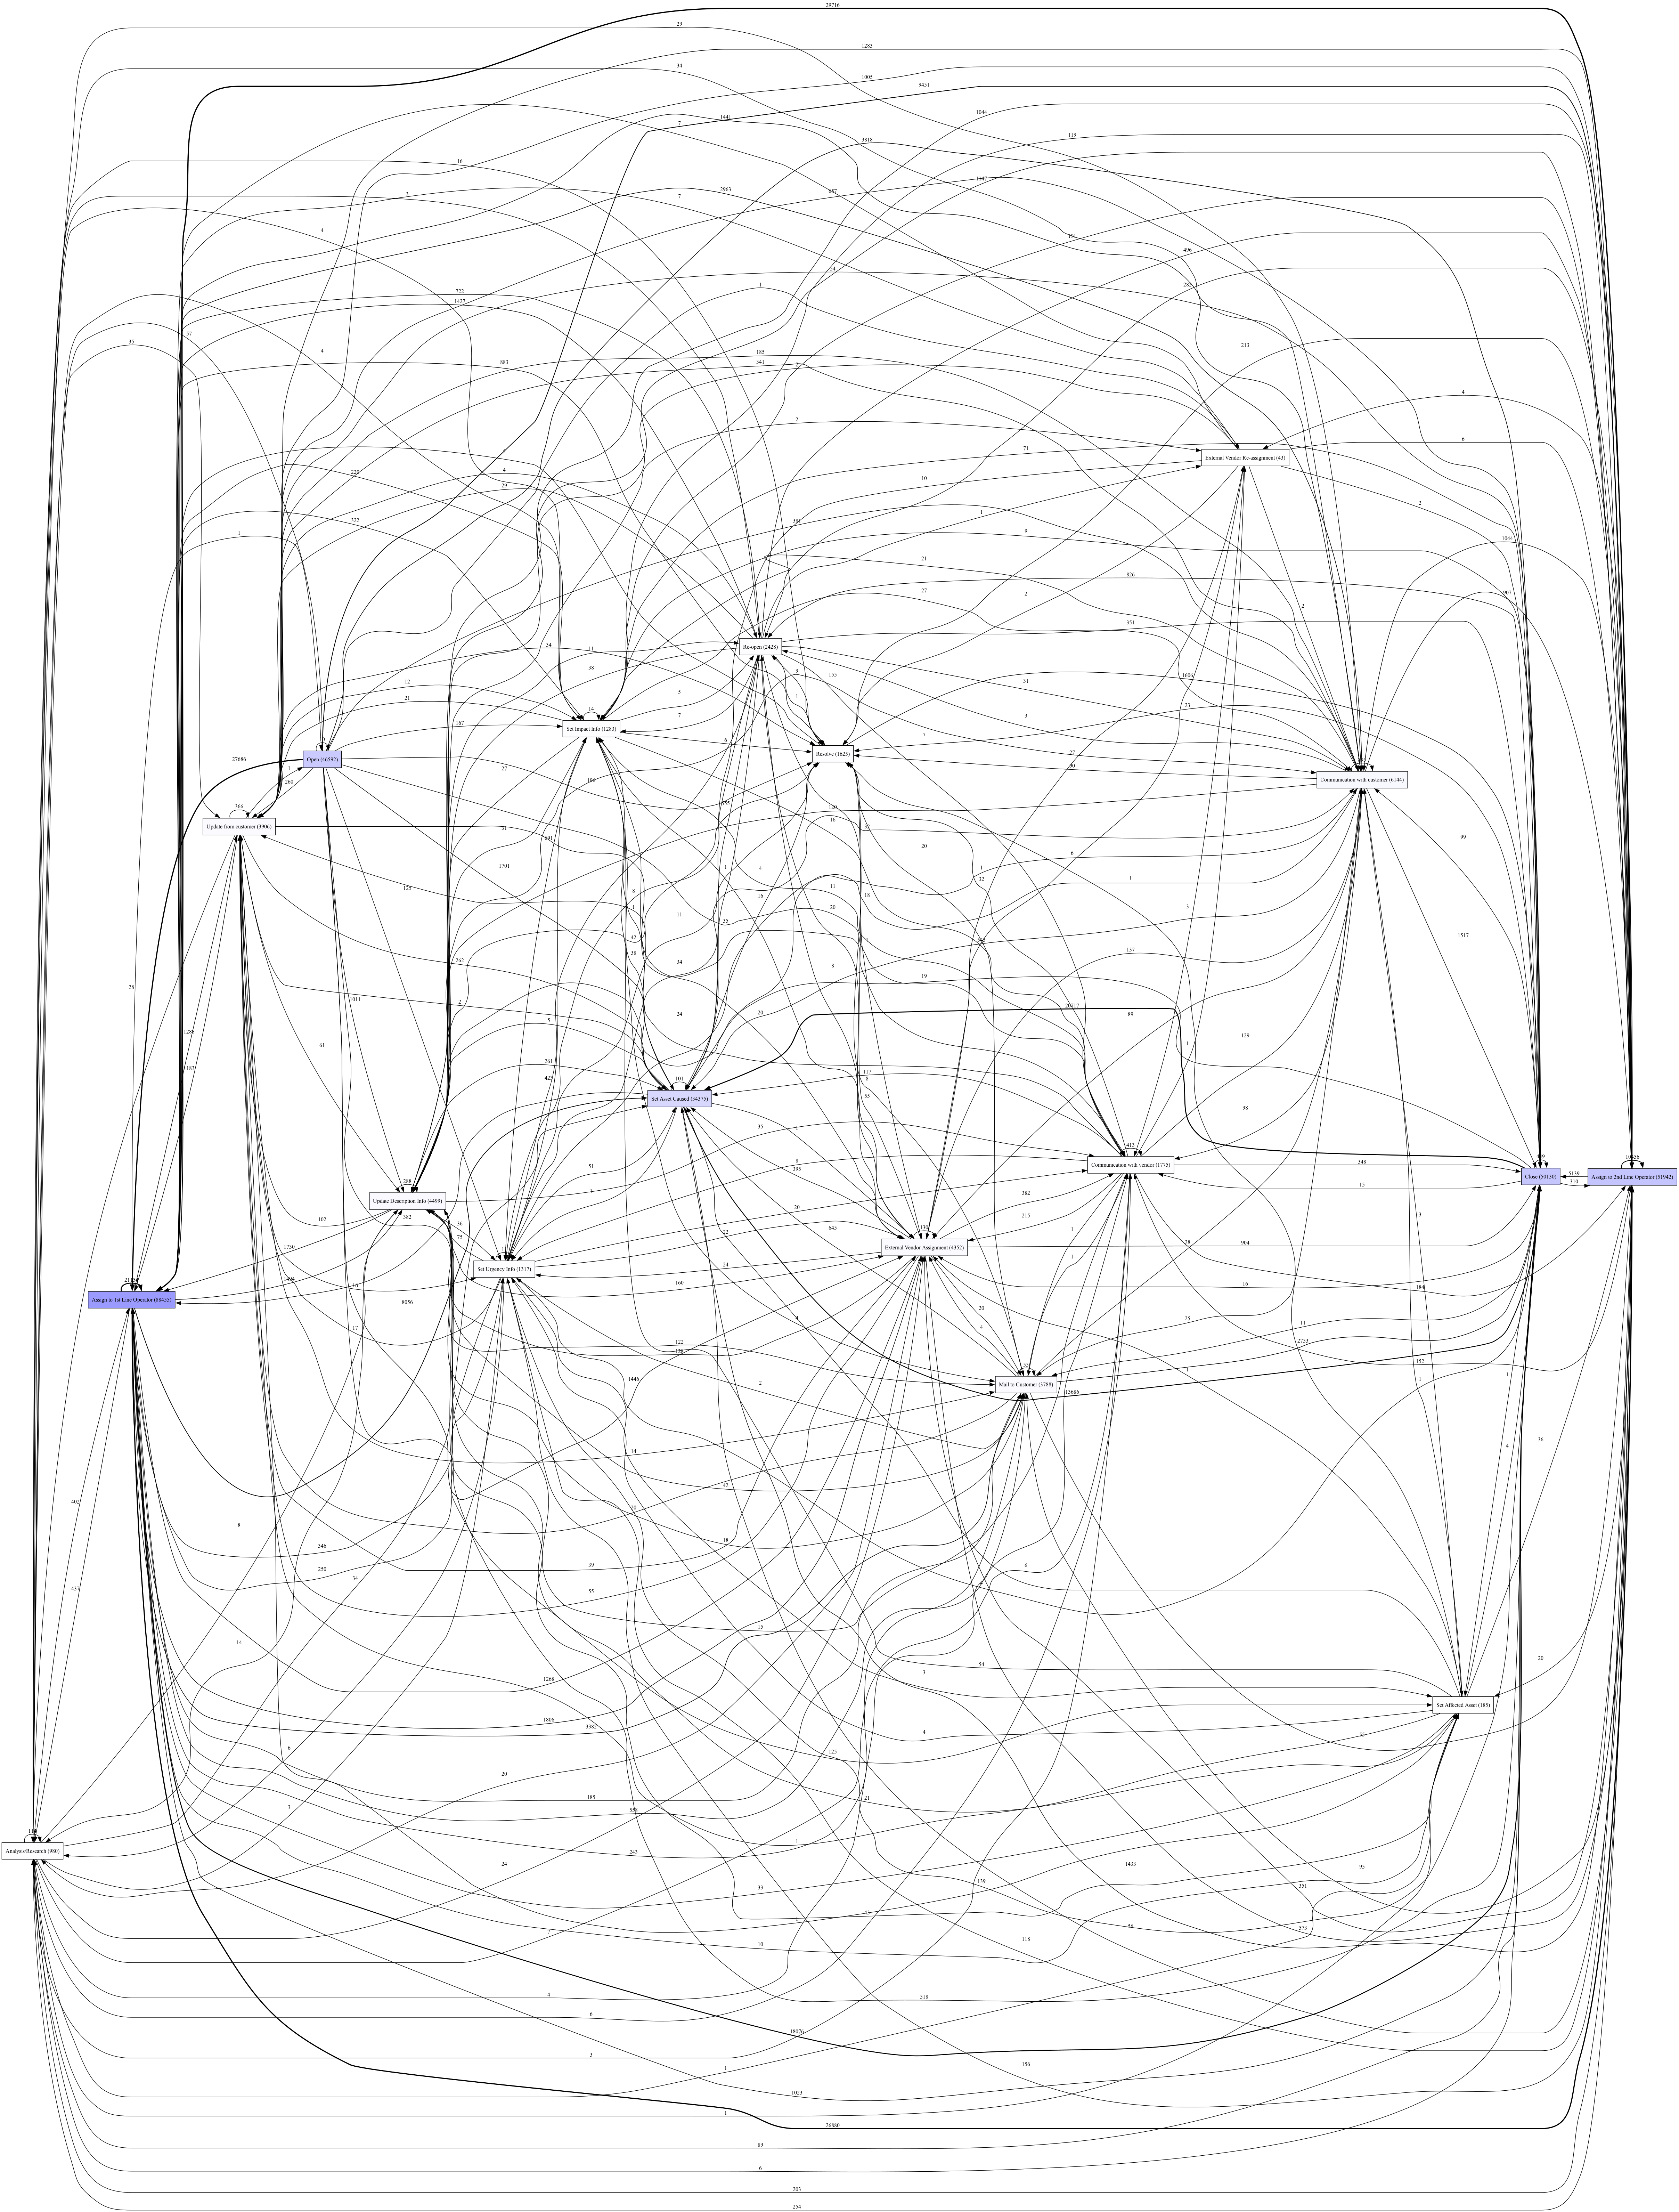

In [13]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)


dfg_visualization.view(gviz)

